# Logistic Regression with One Neuron

Version 1.05

(C) 2020 - Umberto Michelucci, Michela Sperti

This notebook is part of the book _Applied Deep Learning: a case based approach, **2nd edition**_ from APRESS by [U. Michelucci](mailto:umberto.michelucci@toelt.ai) and [M. Sperti](mailto:michela.sperti@toelt.ai).

The purpose of this notebook is to give an example of an application of Logistic Regression performed with One Neuron to a dataset taken from real world.

## Notebook Learning Goals

At the end of the notebook you are going to have a clear idea of what logistic regression is, seen through a practical example. It is very instructive to compare this notebook with *Linear_Regression_with_one_neuron.ipynb* one, since they both are applications of the One Neuron model, used to solve different problems. Along this notebook you will be provided with information about this model to notice similarities and differences with the Linear Regression one. You are going to see how simple is using Keras and how, changing a few parameters, you can easily obtain a different model that can solve a different problem.

## Real Case Example: **Blood Cells Detection**

### Dataset Overview

In this notebook we will use the BCCD Dataset, a small-scale dataset for blood cells detection. The dataset will be downloaded from its GitHub repository.

From this dataset, nicolaschen1 developed two Python scripts to make preparation data for recognition of abnormalities in blood cells on medical images. In the notebook, a slightly modified version of the two scripts will be used.

1. a script to create the pandas dataframe with all data needed: *filename*, *cell_type*, *xmin*, *xmax*, *ymin*, *ymax*, 
2. a script to plot the boxes for each image and save it in a new directory.

The Image Type is jpeg(JPEG) with Width x Height: 640 x 480.

The dataset contains three kind of labels::

1. *RBC* (Red Blood Cell)
2. *WBC* (White Blood Cell)
3. *Platelets*

To keep it simple, we will consider only RBC and WBC to be predicted. In detail, we will face a typical classification problem. The model which will be built is made of one neuron and will predict if an image contains RBC or WBC from `xmin`, `xmax`, `ymin` and `ymax` variables.

### Libraries and Dataset Import

This section contains the necessary libraries (such as tensorflow or pandas) you need to import to run the notebook.

In [ ]:
# This command install code from the tensorflow docs repository.
# We need to use tensorflow_docs.modeling function when training our model.
# This function will generate a report on the network's perfomances
# step by step during the training phase (see Training Phase section of the
# notebook). 

# You can safely ignore this cell if you don't understand what it does.

!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-u6l28m4v
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-u6l28m4v
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0d7cf3b307cf13e5aadea359db22a77a1cb04f499_-cp36-none-any.whl size=146696 sha256=408592b6da363168157ef889afa05405fcbef6e2e74a54a4acd891cb5ceebac4
  Stored in directory: /tmp/pip-ephem-wheel-cache-6e3wnocm/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [ ]:
# general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling

# ignore warnings
import warnings
warnings.simplefilter('ignore')

The following cells are needed to **download** the dataset. You don't need to understand all the download and processing steps, since the focus of this section is to apply a logistic regression model to a real case dataset (therefore you can just execute the following cells, ignoring their content). If you are interested in the details, you can find the complete code in the /modules folder.

Now we clone the repository for the book, to be able to access the modules that we have written for all the juypter notebooks, and the repository which contains the dataset.

In [ ]:
# Referring to the following cell, if you want to re-clone a repository
# inside the google colab instance, you need to delete it first. 
# You can delete the repositories contained in this instance executing 
# the following two lines of code (deleting the # comment symbol).

# !rm -rf ADL-Book-2nd-Ed 
# !rm -rf BCCD_Dataset

In [ ]:
# This command actually clone the repository of the book in the google colab
# instance. In this way this notebook will have access to the modules
# we have written for this book.

# Please note that in case you have already run this cell, and you run it again
# you may get the error message:
#
# fatal: destination path 'ADL-Book-2nd-Ed' already exists and is not an empty directory.
# 
# In this case you can safely ignore the error message.
!git clone https://github.com/toelt-llc/ADL-Book-2nd-Ed.git

fatal: destination path 'ADL-Book-2nd-Ed' already exists and is not an empty directory.


In [ ]:
# We also clone the repository containing the dataset. 

!git clone https://github.com/Shenggan/BCCD_Dataset.git

fatal: destination path 'BCCD_Dataset' already exists and is not an empty directory.


In [ ]:
# This cell imports some custom written functions that we have created to 
# make the loading of the data and the plotting easier. You don't need 
# to undertsand the details and you can simply ignore this cell.
# Simply run it with CMD+Enter (on Mac) or CTRL+Enter (Windows or Ubuntu) to
# import the necessary functions.

import sys
sys.path.append('ADL-Book-2nd-Ed/modules/')

from read_bccd_dataset import read_data
from style_setting import set_style

In [ ]:
# This cell provides the dataset on which you will implement the logistic regression model.

# After cell's execution, you will have a pandas dataframe containing filenames,
# features (xmin, xmax, ymin, ymax), and labels (cell_type).

# You don't need to understand the implementation's details and you can simply ignore this cell.
# Simply run it with CMD+Enter (on Mac) or CTRL+Enter (Windows or Ubuntu) to
# import the necessary functions.

rd = read_data()
dataset = rd.preprocess_bccd_dataset()
dataset_reduced = dataset.loc[(dataset['cell_type'] == 'RBC') | (dataset['cell_type'] == 'WBC')]
bccd_features = dataset_reduced[['xmin', 'xmax', 'ymin', 'ymax']]
bccd_labels = dataset_reduced['cell_type']

Now you have all the necessary elements to successfully implement this tutorial. **Let's have a look at our data**:

In [ ]:
num_observations = len(bccd_features)
print('Number of total samples: ', num_observations)

Number of total samples:  4527


In [ ]:
bccd_features.head()

,xmin,xmax,ymin,ymax
0,349,499,120,206
1,343,437,272,357
2,184,283,292,378
3,253,352,240,326
4,408,505,282,393


The dataset is made of **4527 observations**, **1 target** column (`cell_type`) and **4 features** (`xmin`, `xmax`, `ymin`, `ymax`).

When working with images, it is useful to get an idea of how they look. Let's plot an example image from our dataset.

In [ ]:
# The following line contains the path to fonts that are used to plot result in
# a uniform way.

f = set_style().set_general_style_parameters()

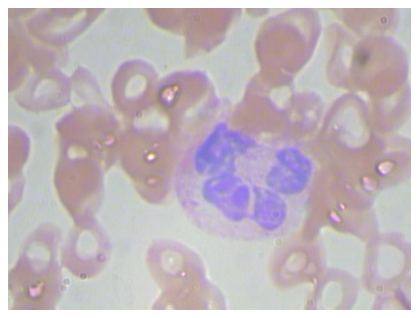

In [ ]:
# Image Example

fig = plt.figure()
ax = fig.add_subplot(111)
# add axes to the image
plt.axis('off')
# read and plot the image
image = plt.imread('BCCD_Dataset/BCCD/JPEGImages/BloodImage_00000.jpg')
plt.imshow(image)

Notice that our features are a simplified version of all the image, in fact for each image we only have 4 values (`xmin`,`xmax`,`ymin` and `ymax`).

### Dataset Splitting

*In any machine learning project, it is a good behaviour to split the dataset you have at your disposal in different subsets*. Plenty of theoretical explanations about this need is present in literature. In the [Further Readings](#fr) section of the notebook you will find some advice on useful material about this topic. To simply explain the concept: when you build a machine learning model, you first need to train (i.e. build) the model and then you have to test it (i.e. verify the model's performances on never seen before data). The roughest way to do this is to split the dataset into two subsets: 80% of the original dataset to train the model (the more data you have the better your model will perform) and the remaining 20% to test it.

Now we build a train and a test set splitting the dataset randomly in two parts with the following proportions: **80%/20%**.

In [ ]:
np.random.seed(42)
rnd = np.random.rand(len(bccd_features)) < 0.8

train_x = bccd_features[rnd] # training dataset (features)
train_y = bccd_labels[rnd] # training dataset (labels)
test_x = bccd_features[~rnd] # testing dataset (features)
test_y = bccd_labels[~rnd] # testing dataset (labels)

print('The training dataset dimensions are: ', train_x.shape)
print('The testing dataset dimensions are: ', test_x.shape)

The training dataset dimensions are:  (3631, 4)
The testing dataset dimensions are:  (896, 4)


### Logistic Regression: the Model

Logistic Regression is a classic classification algorithm. Our model will be made of **one neuron** and its goal will be to recognize two classes (labeled as 0 or 1, referring to RBC or WBC inside a cell image). This is an example of a *binary classification problem*.

Differently from Linear Regression, the activation function will be a **sigmoid function** (leading to a different neuron's output) and the cost function will be the **cross-entropy**. In the case of Linear Regression an identity activation function and a MSE cost function were used.

The formula of the cross-entropy for one observation is the following:

$$
L(\hat{y}^{(i)},y^{(i)})=-(y^{(i)}\log{\hat{y}^{(i)}}+(1-y^{(i)})\log({1-\hat{y}^{(i)}}))
$$

In th presence of more than one observation. the cost function is the sum over all observations:

$$
J({\bf w},b)=\frac{1}{m}\sum_{i=1}^{m}{L(\hat{y}^{(i)},y^{(i)})}
$$

If you are interest in the details concerning cross-entropy, you can find additional material in the [Further Readings](#fr) section of this notebook.

The neuron will give as **output** the probability of the input to be of class 1: $P(y=1|x)$. Then, images will be classified of class 1 if $P(y=1|x) > 0.5$ or of class 0 if $P(y=1|x) < 0.5$. In the Linear Regression example, the neuron's output was the continuous predicted variable.

Since we want our neuron to output a probability, the activity function will need to assume values between 0 and 1. The formula of the sigmoid function is the following:

$$
\sigma(z)=\frac{1}{1+e^{-z}}
$$

In [ ]:
# The following lines are need to convert the labels from RBC/WBC notation to 0/1 notation.
# This is fundamental to correctly train the net.

train_y_bin = np.zeros(len(train_y))
train_y_bin[train_y == 'WBC'] = 1

test_y_bin = np.zeros(len(test_y))
test_y_bin[test_y == 'WBC'] = 1

### Structure of the Net

The following function builds the one neuron model for logistic regression. The implementation is very similar to that of Linear Regression. The differences, as already mentioned, are the activation function, the cost function and the metrics (accuracy in this case, which we will analyze more in detail in the testing phase).

In [ ]:
def build_model():

  # one unit as network's output
  # sigmoid function as activation function
  # sequential groups a linear stack of layers into a tf.keras.Model
  # activation parameter: if you don't specify anything, no activation 
  # is applied (i.e. "linear" activation: a(x) = x).
  model = keras.Sequential([ 
    layers.Dense(1, input_shape = [len(train_x.columns)], activation = 'sigmoid')
  ])

  # optimizer that implements the RMSprop algorithm
  optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001)

  # the compile() method takes a metrics argument, which can be a list of metrics
  # loss = cross-entropy, metrics = accuracy,
  model.compile(loss = 'binary_crossentropy',
                optimizer = optimizer,
                metrics = ['binary_crossentropy','binary_accuracy'])
  
  return model

In [ ]:
model = build_model()

Let's have a look at the model summary:

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


**Learning rate** is a very important parameter of the optimizer. In fact, it strongly influences the convergence of the minimization process. It is a common and good behaviour to try different learning rate values and see how the model's convergence changes. You can find further reading advices about this topic in the [Further Readings](#fr) section of this notebook.

### Training Phase (Model's Learning Phase)

Training our neuron means finding the weights and biases that minimize a chosen function (usually called the **cost function** and typically indicated by $J$). The cost function we chose to minimize in our logistic regression task is the **cross-entropy**. The most famous numerical method to find the minimum of a given function is the **gradient descent** (it is suited for cases in which the solution can not be found analytically, such as all neural network applications). In our example we used the RMSprop algorithm as optimizer.

The minimization process is iterative, therefore it is necessary to decide when to stop it. The simplest way is to set a number of repetitions (called **epochs**) and to run the algorithm that fixed number of times. Then, results are checked to see if an optimal point has been reached. If not, the number of epochs is increased.  

We start training our model for **500** epochs and we look at the summary in terms of performances (accuracy). 

In [ ]:
EPOCHS = 500

history = model.fit(
  train_x, train_y_bin,
  epochs = EPOCHS, verbose = 0,
  callbacks = [tfdocs.modeling.EpochDots()])


Epoch: 0, binary_accuracy:0.3451,  binary_crossentropy:37.0837,  loss:37.0837,  
....................................................................................................
Epoch: 100, binary_accuracy:0.9581,  binary_crossentropy:0.1588,  loss:0.1588,  
....................................................................................................
Epoch: 200, binary_accuracy:0.9733,  binary_crossentropy:0.1039,  loss:0.1039,  
....................................................................................................
Epoch: 300, binary_accuracy:0.9780,  binary_crossentropy:0.0808,  loss:0.0808,  
....................................................................................................
Epoch: 400, binary_accuracy:0.9793,  binary_crossentropy:0.0763,  loss:0.0763,  
....................................................................................................

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,binary_crossentropy,binary_accuracy,epoch
495,0.070310,0.070310,0.979069,495
496,0.068867,0.068867,0.979069,496
497,0.070882,0.070882,0.979895,497
498,0.072805,0.072805,0.980446,498
499,0.069172,0.069172,0.981272,499


You can noticed that while the number of epochs increases, the MSE is minimized. But *which is the best number of epochs to set*? A possible hint can be given by the plot of the **cost function vs. number of iterations**. Let's plot it. If you are interested in plotting details you can find the complete code inside the /module folder.

The cost function vs. number of iterations plot is also useful to evaluate the model's convergence for different learning rates.

In [ ]:
# The following line contains the path to fonts that are used to plot result in
# a uniform way.

f = set_style().set_general_style_parameters()

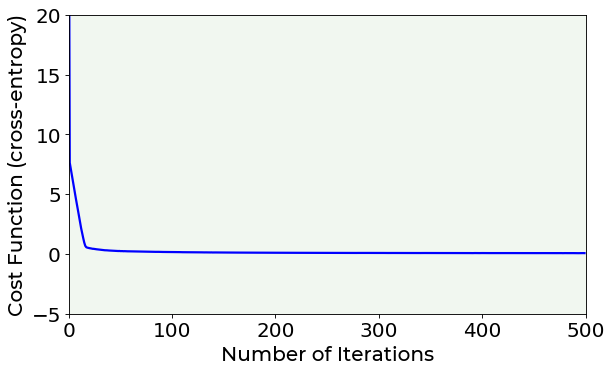

In [ ]:
# Cost Function vs. Number of Iterations PLOT

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(hist['epoch'], hist['binary_crossentropy'], color = 'blue')

plt.ylabel('Cost Function (cross-entropy)', fontproperties = fm.FontProperties(fname = f))
plt.xlabel('Number of Iterations', fontproperties = fm.FontProperties(fname = f))

plt.ylim(-5, 20)
plt.xlim(0, 500)

plt.axis(True)
plt.show()

Looking at the previous plot, you can notice that, after 100 epochs, the cost function remains almost constant in its value, indicating that a minimum has been reached.

### Testing Phase (Model's Performances Evaluation)

Now, to know if the model you have just built is suited to be applied to unseen data, you have to check its performances over the test set. Moreover, an optimizing metric must be chosen. For a binary classification problem, a classic metric is **accuracy** which can be understood as a measure of how well the classifier correctly identified the two classes of the dataset.

$$
accuracy=\frac{\text{number of cases correctly identified}}{\text{total number of cases}}
$$

where the number of cases correctly identified is the sum of all positive samples and negative samples (i.e. all 0s and 1s) that were correctly classified, usually called *true positives* and *true negatives*.

In [ ]:
test_predictions = model.predict(test_x).flatten() # predict cell type with the built logistic regression model

In [ ]:
# The following lines compute the accuracy on the test set.

test_predictions1 = test_predictions > 0.5
tp = np.sum((test_predictions1 == 1) & (test_y_bin == 1))
tn = np.sum((test_predictions1 == 0) & (test_y_bin == 0))
accuracy_test = (tp + tn)/len(test_y)
print('The accuracy on the test set is equal to: ', int(accuracy_test*100), '%.')

The accuracy on the test set is equal to:  96 %.


Notice that we could achieve a very good accuracy using only one neuron.

## Exercises

1. [*Medium Difficulty*] Try to change the `learning_rate` parameter and see how the model's convergence changes. Then try to reduce the `EPOCHS` parameter and see when the model cannot reach convergence.
2. [*Medium Difficulty*] Try to see how model's results change based on the training dataset's size (reduce it and use different sizes comparing the final results).
3. [*Hard Difficulty*] Try to add to labels `Platelets` samples and generalize the binary classification model to a multiclass one (3 possible classes). 

## References

1. https://www.tensorflow.org/datasets/catalog/bccd (dataset explanation)
2. Michelucci, Umberto. "Applied Deep Learning." A Case-Based Approach to Understanding Deep Neural Networks (2018) (mathematical details about how to perform logistic regression with one neuron)

## Further Readings <a name = 'fr'></a>

**Dataset Splitting, Overfitting & Underfitting**

1. Lever, Jake, Martin Krzywinski, and Naomi Altman. "Points of significance: model selection and overfitting." (2016): 703.
2. Srivastava, Nitish, et al. "Dropout: a simple way to prevent neural networks from overfitting." The journal of machine learning research 15.1 (2014): 1929-1958.

**Cross-entropy**

1. https://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/

**Learning Rate**

1. Bengio, Yoshua. "Practical recommendations for gradient-based training of deep architectures." Neural networks: Tricks of the trade. Springer, Berlin, Heidelberg, 2012. 437-478.